# Mini-project n°2 – Conditional VAEs

Voici la bibliographie que nous avons utilisé : 
- https://arxiv.org/abs/1312.6114
- https://papers.nips.cc/paper_files/paper/2015/hash/8d55a249e6baa5c06772297520da2051-Abstract.html

- https://towardsdatascience.com/conditional-variational-autoencoders-for-text-to-image-generation-1996da9cefcb/
- https://creatis-myriad.github.io/tutorials/2022-09-12-tutorial-cvae.html#introduction


## MNIST data-set and librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchvision.transforms.functional as functional
import torch.nn as nn
from torchvision.datasets import FashionMNIST 
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### On télécharge le dataset FashionMNIST

In [2]:
transform = transforms.Compose([transforms.ToTensor(),])

train_dataset = FashionMNIST(root=".",train=True,download=True,transform=transform)
test_dataset = FashionMNIST(root=".",train=False,download=True,transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=False)

print("taille du data_set d'entrainement:",len(train_dataset))
print("taille du data_set de test:",len(test_dataset))

taille du data_set d'entrainement: 60000
taille du data_set de test: 10000


On visualise un exemple de chaque classe

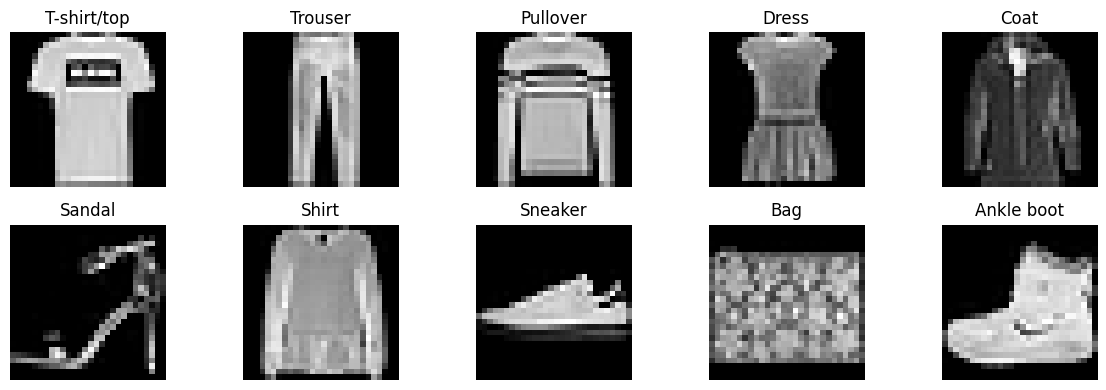

In [3]:
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat","Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"] # Les 10 classes de Fashion-MNIST
label_size=10
examples = {}

for img, label in train_dataset:
    if label not in examples:
        examples[label] = img
    if len(examples) == 10:
        break

plt.figure(figsize=(12, 4))
for label, img in examples.items():
    plt.subplot(2, 5, label + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(classes[label])
    plt.axis("off")

plt.tight_layout()
plt.show()

# Phase d'entrainement

Un cVAE reprend la philosophie d'un VAE classique. Ce qui est nouveau est l'ajout de l'information de la catégorie qu'on souhaite générer. On appelle cette information **c** par la suite.

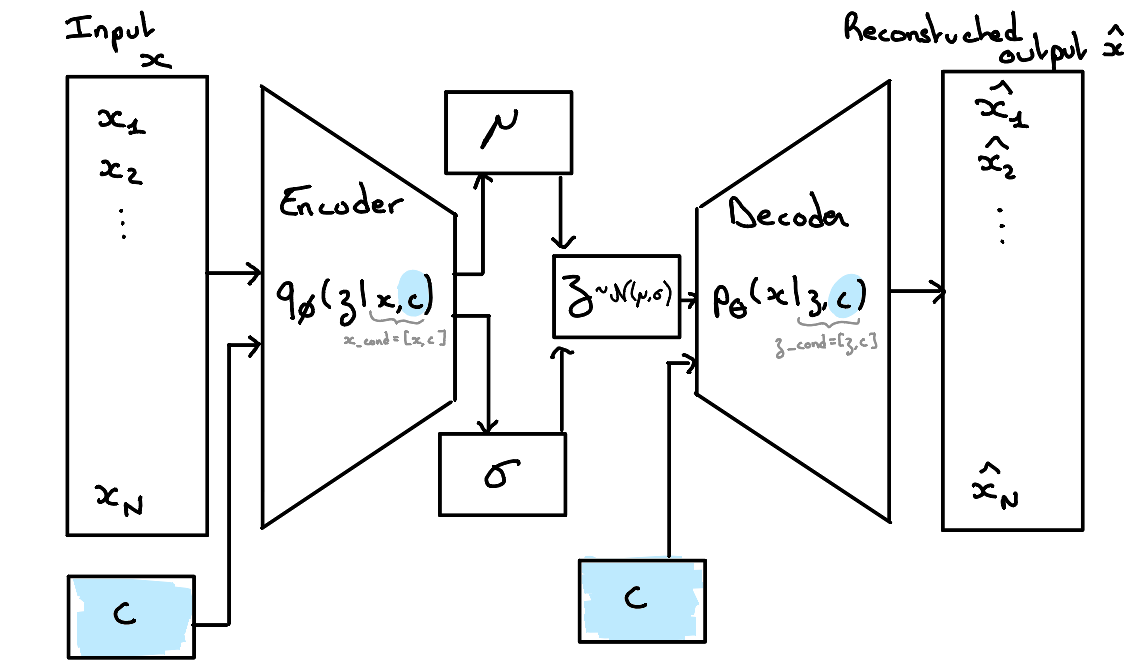

On encode l'information conditionnelle dans **c**. Pour cela on doit concatener **x** et **c** : [x,c]. Pour faire ça en Python, il faut que **c** soit de la même taille que **x**.  
On encode la catégorie qui nous intéresse avec un vecteur "one-hot", puis on le redimensionne pour qu'il soit de taille (n_batch,n_catégories,img_size).  
  
On s'est très fortement inspiré de ce qu'on avait déjà fait en TP avec le VAE pour le choix de l'architecture de l'encoder et du decoder. On a simplement adapté les dimensions pour pouvoir prendre en considération l'information **c**. Voici les arguments qui justifie les choix des différentes couches :

### Encodeur
- **Couches convolutionnelles :** Capturent efficacement les corrélations spatiales dans les images.  
- **Canaux d'entrée :** `1 + n_classes` pour concaténer les labels en one-hot, permettant à l'encodeur d'apprendre des représentations latentes spécifiques à chaque classe.  
- **Cartes de caractéristiques :** 32 → 64 pour fournir une capacité suffisante pour des jeux de données simples tout en gardant le calcul raisonnable.  
- **Activation (ReLU) :** Ajoute de la non-linéarité pour modéliser des patterns complexes.  
- **Sortie :** Les features aplaties sont projetées vers la moyenne latente `mu` et la log-variance `logvar`.

### Décodeur
- **Couche linéaire :** Transforme le vecteur latent + label conditionnel en cartes de caractéristiques initiales pour l'upsampling.  
- **Convolutions transposées :** Upsample pour reconstruire la taille originale de l'image (7x7 → 14x14 → 28x28).  
- **Activation (Sigmoid) :** Assure que les valeurs des pixels en sortie soient comprises entre 0 et 1.


In [ ]:
class cVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(cVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = label_size                                         # On a besoin de l'info du nombre de label

        self.embedding = nn.Embedding(self.num_classes, self.num_classes)
        # Encoder 
        self.encoder = nn.Sequential(
            nn.Conv2d(1+label_size, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),            # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),           # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim) 
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim) 
        self.fc_decode = nn.Linear(latent_dim + label_size, 128 * 4 * 4) 
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # Output: (1, 28, 28)
            nn.Sigmoid()
        )
    
    def encode(self, x, c):
        c_one_hot = F.one_hot(c, num_classes=self.num_classes).float()        # (batch, 10)
        c_img = c_one_hot.unsqueeze(2).unsqueeze(3)                           # (batch, 10, 1, 1)
        c_img = c_img.expand(-1, -1, 28, 28)                                  # (batch, 10, 28, 28)

        x_cond = torch.cat([x, c_img], dim=1)                                 # (batch, 1+10, 28, 28)
        
        h = self.encoder(x_cond)
        h = h.view(-1, 128 * 4 * 4)

        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, c):
        c_one_hot = F.one_hot(c, num_classes=self.num_classes).float()        # (batch, 10)
        z_cond = torch.cat([z, c_one_hot], dim=1)                             # (batch, latent_dim + label_size)

        x = self.fc_decode(z_cond)
        x = x.view(-1, 128, 4, 4)
        return self.decoder(x)

    def forward(self, x, c):
        mu, logvar = self.encode(x,c)
        z = self.sample(mu, logvar)
        return self.decode(z, c), mu, logvar

Pour utiliser un CVAE de manière classique, on utilise la même fonction loss que pour le VAE :

In [6]:
def loss_function(recon_x, x, mu, logvar, beta):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

Cependant dans certains cas, par exemple si on souhaite inférer sans donner l'information sur la catégorie, il est plus adéquat d'utiliser une loss function hybride. (https://papers.nips.cc/paper_files/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf, partie 4.2)  
Dans notre cas, on reste sur la loss function : **BCE +** $\beta$ **KLD**

On a maintenant tout ce qu'il faut pour entrainer notre modèle. Pour le choix des hyper-paramètres, on a gardé ceux du VAE vu en TP initialement. Vu que nous avons des bons résultats, nous les avons gardé. Voici leurs avantages : 
| hyper-paramètre | Choix | Raison |
|----------------|--------|-----------|
| Batch size     | 128    | Gradient stable et en accord avec la mémoire GPU. |
| Learning rate  | 1e-3   | Point de départ standart pour Adam optimizer; Permet d'avoir de la stabilité et convergence. |
| Number of epochs | 30   | Permet de converger sur des jeux de données simples. |
| Optimizer      | Adam   | Efficace pour entrainer des VAE avec la possibilité de modifier 'learning rate'. |
| KL weight (β)  | 1      | Standard VAE KL-divergence; on le modifiera plus tard |
| latent_dim  | 2      | Pratique pour visualiser |

Si on choisit **latent_dim** plus grand, on aura un meilleur équilibre entre la compréssion d'information et la qualité de la reconstruction. Si on le prend trop grand, on risque d'avoir de l'overfitting


In [ ]:
# hyper-paramètres
batch_size = 128
latent_dim = 2
learning_rate = 1e-3
epochs = 30
beta = 1

def Train(beta): # On passe beta en paramètre pour plus tard (quand on regarde son influence sur l'espace latent)
    cvae = cVAE(latent_dim=latent_dim)
    cvae.to(device)
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

    losses = []

    for epoch in range(1, epochs + 1):
        cvae.train()
        running_loss = 0.0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            recon_batch, mu, logvar = cvae(data, labels)
            loss,_,_ = loss_function(recon_batch, data, mu, logvar,beta)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)

    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), losses, marker='o', label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss per Epoch, KL Weight = {beta}')
    plt.grid(True)
    plt.legend()
    plt.show()
    return cvae

Pour la suite, on va regarder 3 modèles différents: CVAE_1, CVAE_10 et CVAE_100. Ces trois modèles sont sensiblement les mêmes, la seule chose qui change est la valeur du poids $\beta$ du KL dans la fonction de perte: 1,10 et 100.

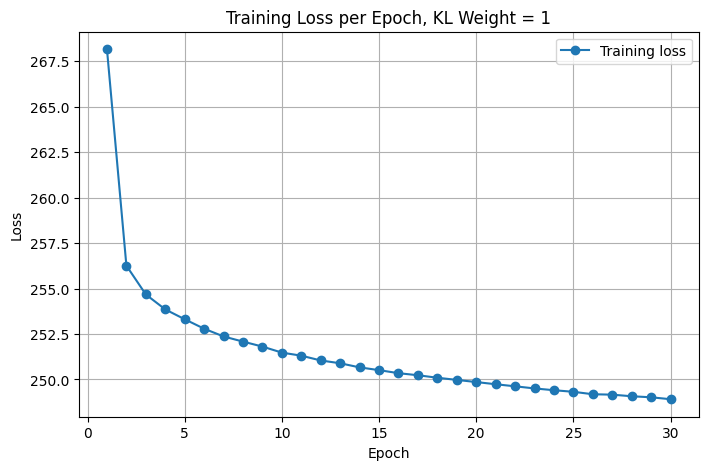

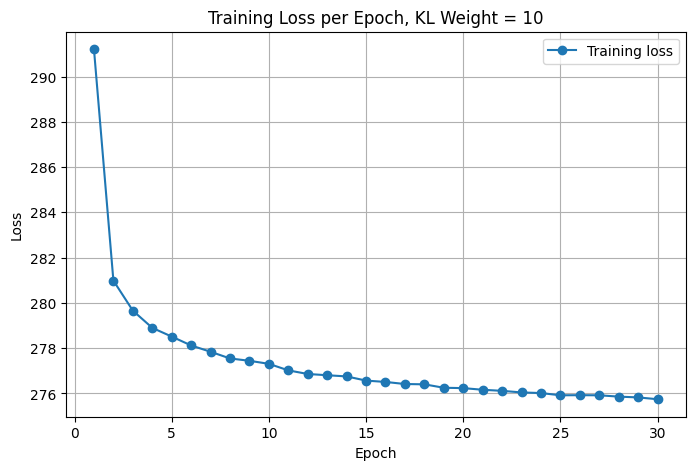

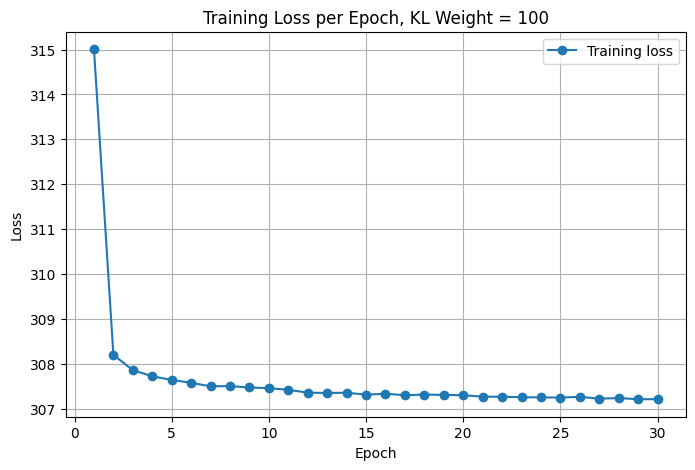

In [8]:
CVAE_1 = Train(1)
CVAE_10 = Train(10)
CVAE_100 = Train(100)

On a des résultats du même ordre de grandeur, il semble que $\beta = 1$ est le plus performant. On pourrait passer un peu de temps pour regarder quel choix de $\beta$ est le plus judicieux mais cela nous semble peu pertinent, les résultats sont déjà satisfaisants.

# Phase d'inférence

Maintenant que les modèles sont entrainés, on passe à la phase d'inférence :

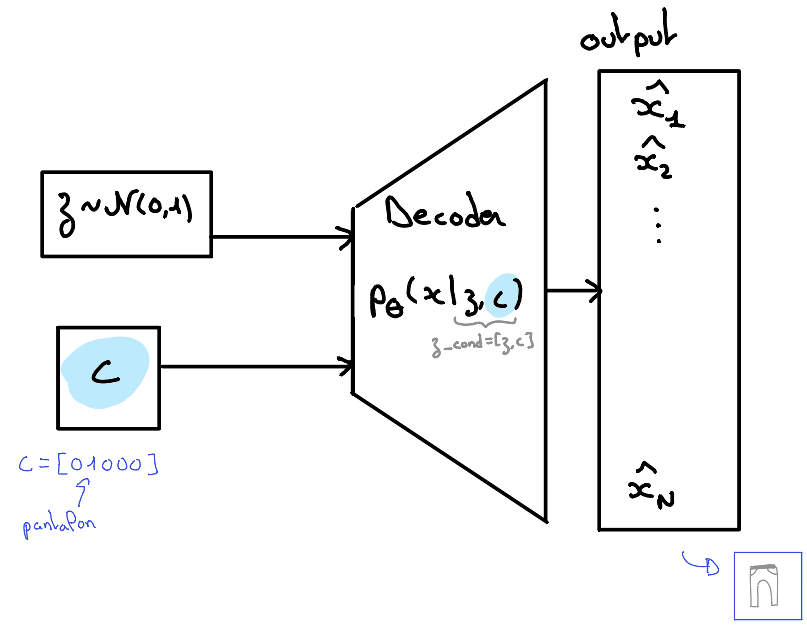

Pour générer de nouvelles images, il suffit de tirer un **z** dans l'espace latent avec un loi normale. On fournit l'information de la catégorie qu'on souhaite générer (**c**), et on passe tout ça dans le décodeur.
Par exemple avec le modèle où $\beta = 1$, on obtient les images suivantes :

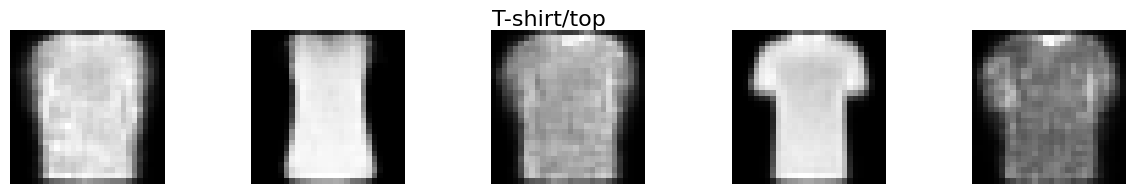

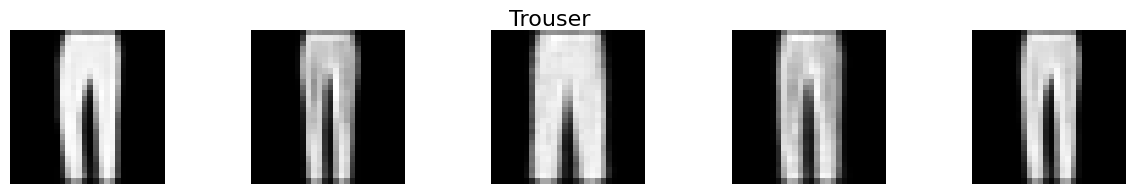

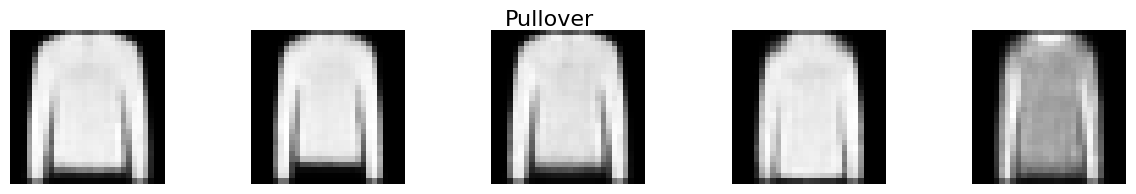

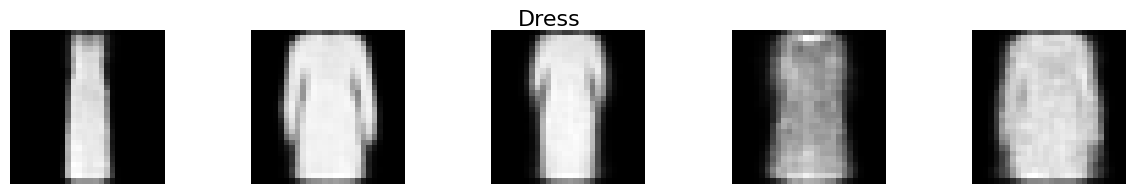

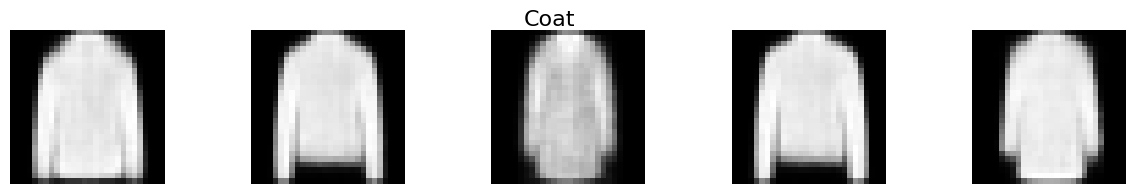

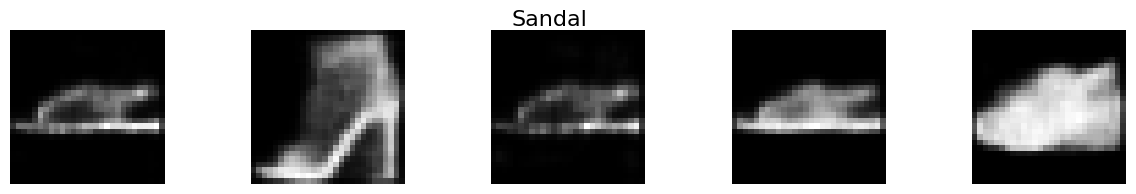

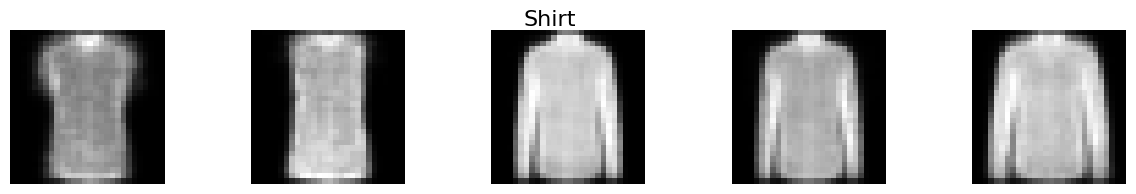

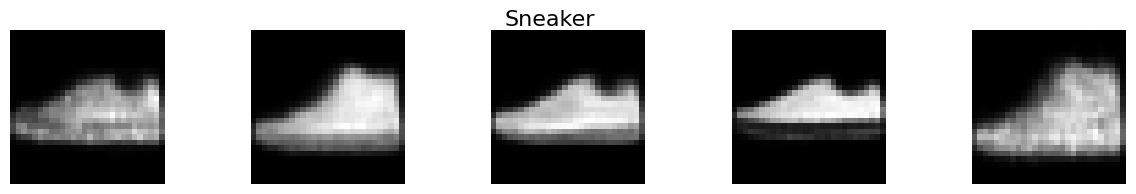

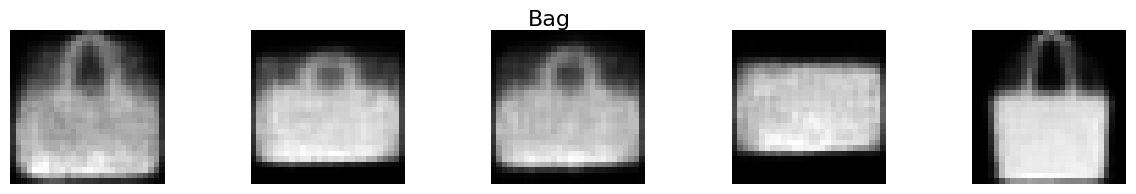

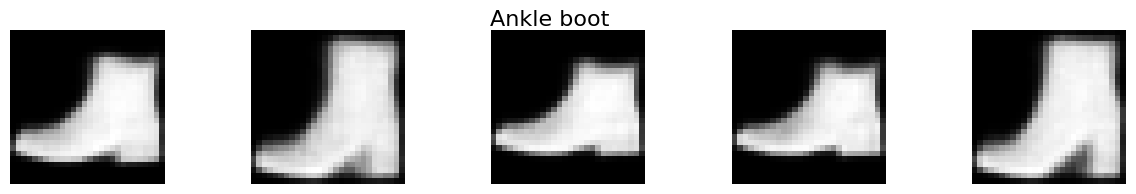

In [ ]:
CVAE_1.eval()
n_samples = 5  # nombre d'images par classe
for class_idx, class_name in enumerate(classes):
    plt.figure(figsize=(15, 2))
    plt.suptitle(class_name, fontsize=16)
    
    for i in range(n_samples):
        c = torch.tensor([class_idx], device=device)
        z = torch.randn(1, latent_dim).to(device)
        generated = CVAE_1.decode(z, c).detach().cpu().squeeze()
        
        plt.subplot(1, n_samples, i+1)
        plt.imshow(generated, cmap="gray")
        plt.axis('off')
    
    plt.show()

#Si on fixe z, on obtiendra toujours la même image au sein de chaque catégorie. Mais on aura bien des images différentes entre les catégories
# (z,0) donne un t-shirt, (z,1) donne un pantalon, etc...

## Visualisation de l'espace latent

On a choisit d'avoir un espace latent en 2 dimensions afin de pouvoir le visualiser.
On va en profiter pour regarder l'impact du poids que l'on donne au KL dans la fonction de loss.


Pour comparer l'impact du poids $\beta$ sur l'organisation de l'espace latent on fait une fonction qui :  
    - Pour chaque modèle,  encode toutes les images du jeu de test afin de récupérer les moyennes $\mu$ des distributions latentes.  
    - Elle concatène toutes les latentes et les labels correspondants pour créer un nuage de points en 2 dimensions.  
    - Elle trace chaque point dans un scatter plot, en utilisant une couleur différente pour chaque classe d'image.  

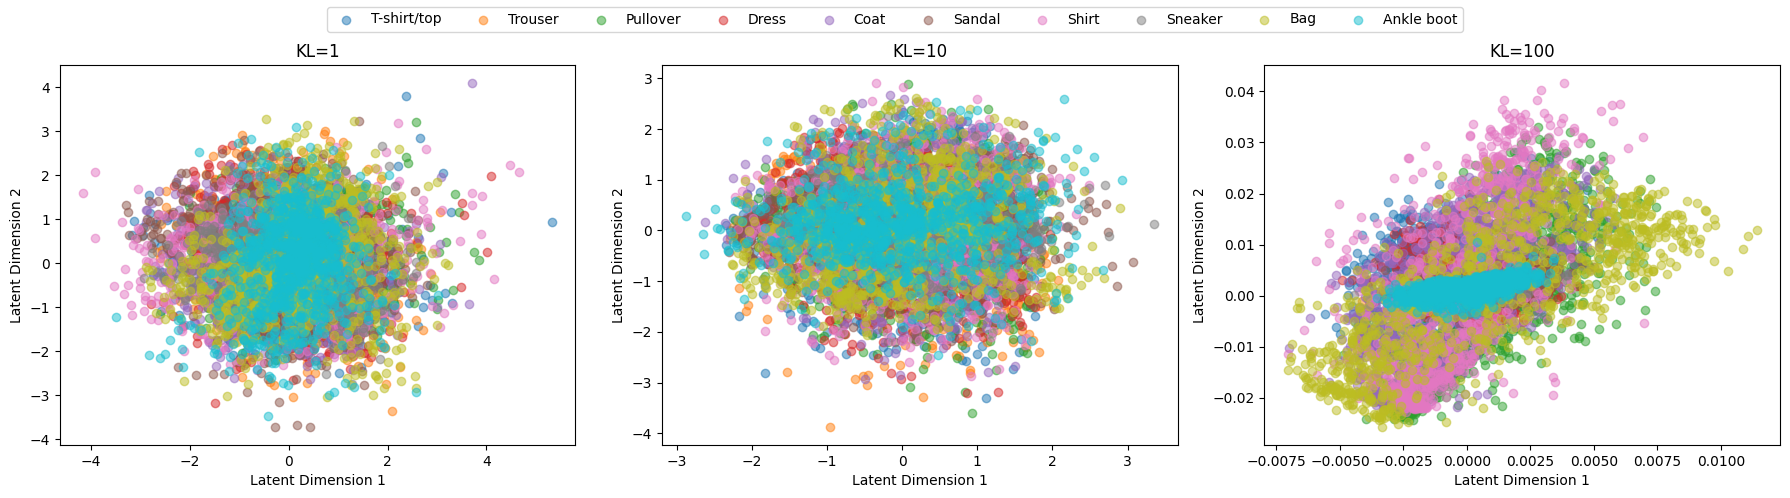

In [10]:
def Visualiser_espaces_latents(models, titles):
    """
    Visualise les espaces latents de plusieurs modèles
    
    models : list de modèles
    titles : list de titres correspondants à chaque modèle
    """
    num_models = len(models)
    fig, axes = plt.subplots(1, num_models, figsize=(6*num_models, 5))

    for ax, model, title in zip(axes, models, titles):
        model.eval()
        latents = []
        labels_list = []

        with torch.no_grad():
            for data, labels in test_loader:
                data = data.to(device)
                labels = labels.to(device)
                
                mu, logvar = model.encode(data, labels)
                latents.append(mu.cpu())
                labels_list.append(labels.cpu())

        latents = torch.cat(latents, dim=0)
        labels_list = torch.cat(labels_list, dim=0)

        for i in range(10):
            idxs = labels_list == i
            ax.scatter(latents[idxs, 0], latents[idxs, 1], label=classes[i], alpha=0.5)

        ax.set_xlabel("Latent Dimension 1")
        ax.set_ylabel("Latent Dimension 2")
        ax.set_title(title)

    # On affiche la légende une seule fois pour toute la figure
    handles, labels_ = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels_, loc='upper center', ncol=10)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


# Exemple d'appel
Visualiser_espaces_latents(
    models=[CVAE_1, CVAE_10, CVAE_100],
    titles=["KL=1", "KL=10", "KL=100"]
)


Pour rappel, la loss est calculé par:  
**Loss = BCE + $\beta$ KLD**  
avec :
- BCE (Binary Cross Entropy) qui mesure la qualité de reconstruction des images.
- KLD (Kullback-Leibler Divergence) qui force la distribution latente q(z∣x) à se rapprocher d’une distribution normale standard N(0,1).

On remarque que plus le poids donné à KL est important, plus on arrive à discerner à l'oeil nu les catégories dans l'espace latent. Par contre tout est regroupé très proche de (0,0). On aura donc surement moins de diversité à la génération au sein de chaque classe.

On va maintenant regarder ce qu'il se passe lors de la génération.
On visualise comment les images générées évoluent lorsque l'on parcourt une grille régulière dans le plan latent pour une classe donnée. 
Pour chaque modèle et chaque classe sélectionnée, nous générons des images à partir de coordonnées latentes $(z_1, z_2)$ uniformément espacées dans un intervalle choisi. 
Ces images sont ensuite assemblées pour former une grande grille représentant le "manifold latent" de la classe.

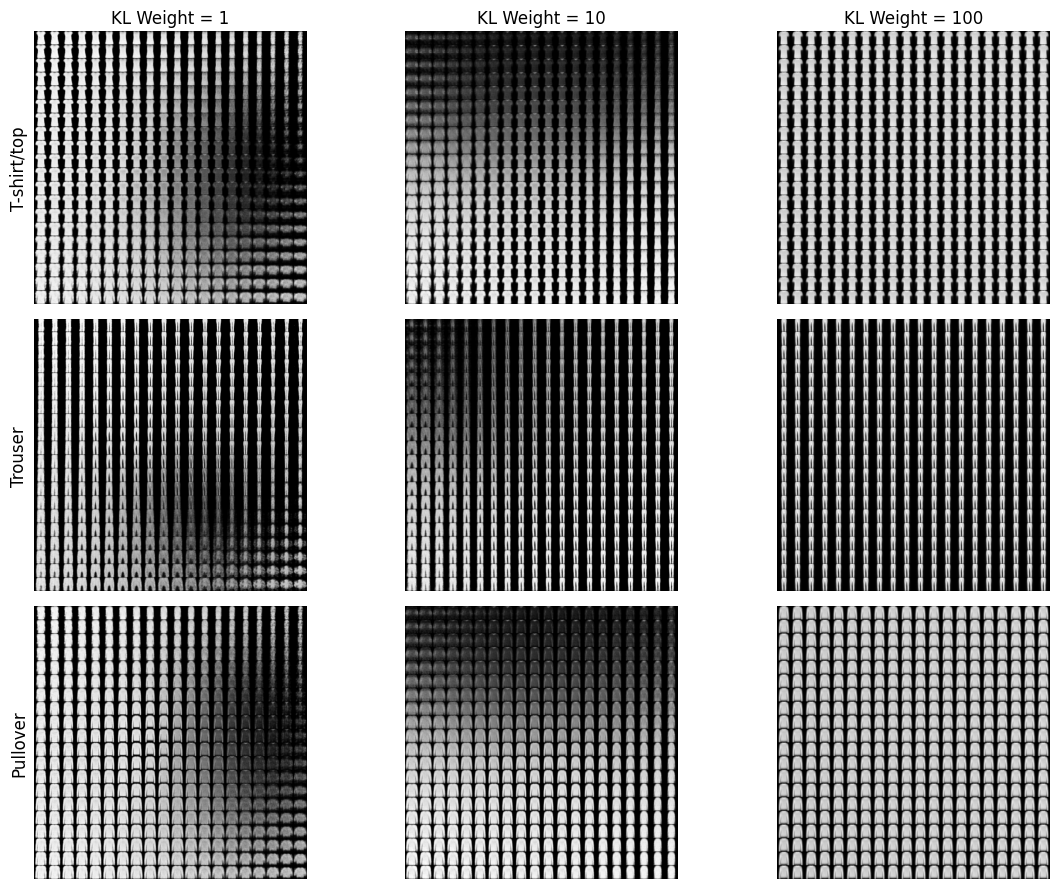

In [11]:
def plot_latent_manifolds_grid(models, betas, labels, device, grid_size=20, scale=3):

    n_labels = len(labels)
    fig, axes = plt.subplots(n_labels, len(models), figsize=(4*len(models), 3*n_labels))

    # Si 1 seul label → axes devient 1D, on force en 2D
    if n_labels == 1:
        axes = axes[np.newaxis, :]

    for row, label in enumerate(labels):
        for col, (model, beta) in enumerate(zip(models, betas)):
            
            model.eval()
            z1 = np.linspace(-scale, scale, grid_size)
            z2 = np.linspace(-scale, scale, grid_size)
            figure = np.zeros((28 * grid_size, 28 * grid_size))

            with torch.no_grad():
                for i, yi in enumerate(z1):
                    for j, xj in enumerate(z2):
                        z = torch.tensor([[yi, xj]], dtype=torch.float32).to(device)
                        y_tensor = torch.tensor([label], dtype=torch.long).to(device)
                        x_hat = model.decode(z, y_tensor)
                        img = x_hat.cpu().view(28, 28).numpy()
                        figure[i*28:(i+1)*28, j*28:(j+1)*28] = img
            
            ax = axes[row, col]
            ax.imshow(figure, cmap="gray")
            ax.set_xticks([])
            ax.set_yticks([])
            ax.tick_params(axis='both', which='both', length=0)
            for spine in ax.spines.values():
                spine.set_visible(False)

            # Titres
            if row == 0:
                ax.set_title(f"KL Weight = {beta}", fontsize=12)

            if col == 0:
                ax.set_ylabel(classes[label], fontsize=12)

    plt.tight_layout()
    plt.show()


plot_latent_manifolds_grid(
    models=[CVAE_1, CVAE_10, CVAE_100],
    betas=[1, 10, 100],
    labels=[0,1,2],             # On choisit ici les habits qu'on veut afficher !
    device=device
)


On observe que plus la valeur de KL Weight ($\beta$) est elevée, plus le modèle arrive à générer la bonne image. Par contre l'espace latent devient plus uniforme. 
Quand on a KL Weight = 100, peut importe la valeur de (z1,z2) on aura la même sortie. Par contre on a beaucoup plus de diversité quand KL Weight est plus bas. Cela peut engendrer des génération incohérentes, mais il y aura de la diversité.

On voit aussi que le modèle mélange les Sandales et les Sneakers pour une valeur plutot faible de $\beta$.

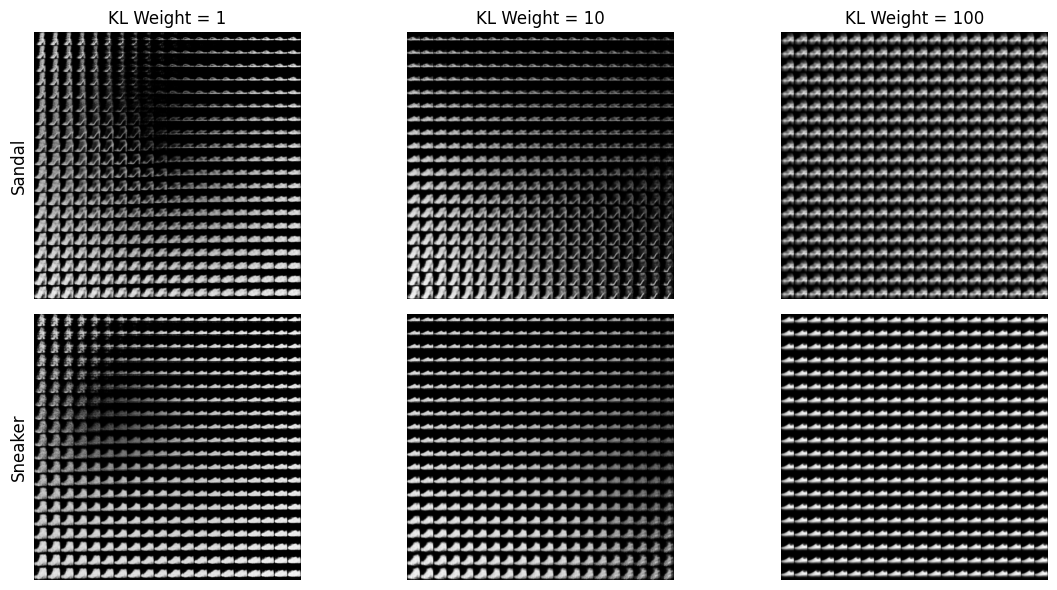

In [12]:
plot_latent_manifolds_grid(models=[CVAE_1, CVAE_10, CVAE_100],betas=[1, 10, 100],labels=[5,7],device=device)